In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [16]:
test_passenger_ids = test_df.pop("PassengerId")
train_df.drop(["PassengerId"], axis=1, inplace=True)

embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df["Embarked"].fillna("Null"))

df_list = [train_df, test_df]

for df in df_list:
    df["Alone"] = (df["SibSp"] == 0) & (df["Parch"] == 0)
    df["Embarked"].fillna("Null", inplace=True)
    df["Embarked"] = embarked_encoder.transform(df["Embarked"])
    df.loc[df["Sex"] == "female", "Sex"] = 0
    df.loc[df["Sex"] == "male", "Sex"] = 1
    df["Sex"] = df["Sex"].astype("int8")
    
    df.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [17]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone
0,0,3,1,22.0,1,0,7.2500,3,False
1,1,1,0,38.0,1,0,71.2833,0,False
2,1,3,0,26.0,0,0,7.9250,3,True
3,1,1,0,35.0,1,0,53.1000,3,False
4,0,3,1,35.0,0,0,8.0500,3,True
5,0,3,1,NaN,0,0,8.4583,2,True
6,0,1,1,54.0,0,0,51.8625,3,True
7,0,3,1,2.0,3,1,21.0750,3,False
8,1,3,0,27.0,0,2,11.1333,3,False
9,1,2,0,14.0,1,0,30.0708,0,False


In [18]:
y = train_df.pop("Survived")

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=0)

categorical_features = ["Alone", "Sex", "Pclass", "Embarked"]
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

final_train_set = lgbm.Dataset(data=train_df, label=y, categorical_feature=categorical_features, free_raw_data=False)

In [21]:
train_df.shape[1]

8

In [22]:
lgbm_params = {
    "boosting_type": "gbdt",
    "application": "binary",
    "learning_rate": 0.05,
    "min_data_in_leaf": 20,
    "feature_fraction": np.sqrt(train_df.shape[1]) / train_df.shape[1],
    "num_leaves": 41,
    "metric": "binary_logloss",
    "drop_rate": 0.15
}

In [23]:
evaluation_results = {}
clf = lgbm.train(
    train_set=train_data,
    params=lgbm_params,
    valid_sets=[train_data, test_data],
    valid_names=["Train", "Test"],
    evals_result=evaluation_results,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20)
optimum_boost_rounds = clf.best_iteration

/Users/numatakouhei/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/numatakouhei/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.539367	Test's binary_logloss: 0.534279
[40]	Train's binary_logloss: 0.47163	Test's binary_logloss: 0.466951
[60]	Train's binary_logloss: 0.431729	Test's binary_logloss: 0.43224
[80]	Train's binary_logloss: 0.405919	Test's binary_logloss: 0.413723
[100]	Train's binary_logloss: 0.386944	Test's binary_logloss: 0.40129
[120]	Train's binary_logloss: 0.372047	Test's binary_logloss: 0.392388
[140]	Train's binary_logloss: 0.359921	Test's binary_logloss: 0.3878
[160]	Train's binary_logloss: 0.350476	Test's binary_logloss: 0.384847
[180]	Train's binary_logloss: 0.342572	Test's binary_logloss: 0.382507
[200]	Train's binary_logloss: 0.336335	Test's binary_logloss: 0.379161
[220]	Train's binary_logloss: 0.331084	Test's binary_logloss: 0.378499
[240]	Train's binary_logloss: 0.326488	Test's binary_logloss: 0.37698
[260]	Train's binary_logloss: 0.322503	Test's binary_logloss: 0.376416
[280]	Train's binary_log

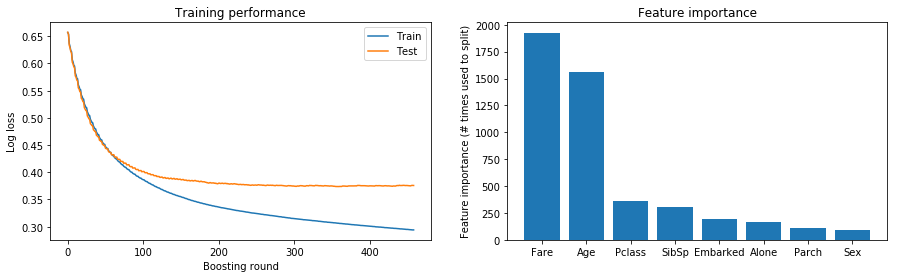

In [24]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

axs[0].plot(evaluation_results["Train"]["binary_logloss"], label="Train")
axs[0].plot(evaluation_results["Test"]["binary_logloss"], label="Test")
axs[0].set_ylabel("Log loss")
axs[0].set_xlabel("Boosting round")
axs[0].set_title("Training performance")
axs[0].legend()

importances = pd.DataFrame(
    {"features": clf.feature_name(),
    "importance": clf.feature_importance()}).sort_values("importance", ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances["importance"])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances["features"])
axs[1].set_ylabel("Feature importance (# times used to split)")
axs[1].set_title("Feature importance")
plt.show()

In [25]:
preds = np.round(clf.predict(X_test))
print(f"Accuracy score = \t {accuracy_score(y_test, preds)}")
print(f"Precision score = \t {precision_score(y_test, preds)}")
print(f"Recall score = \t {recall_score(y_test, preds)}")
print(f"F1 score = \t {f1_score(y_test, preds)}")

Accuracy score = 	 0.8324022346368715
Precision score = 	 0.8305084745762712
Recall score = 	 0.7101449275362319
F1 score = 	 0.7656250000000001


In [26]:
clf_final = lgbm.train(
    train_set=final_train_set,
    params=lgbm_params,
    num_boost_round=optimum_boost_rounds,
    verbose_eval=0)

y_pred = np.round(clf_final.predict(test_df)).astype(int)

/Users/numatakouhei/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [27]:
output_df = pd.DataFrame({"PassengerId": test_passenger_ids, "Survived": y_pred})

In [28]:
output_df.to_csv("lgbm1.csv", index=None)